In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification

# Specify the file path
file_path = "Merged_Aneurysm.csv"

# Load the CSV file into a Pandas DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the data has been loaded correctly
data.head()


,case_id,patient_id,aneurysmLocation,aneurysmType,ruptureStatus,age,sex,multipleAneurysms,sacVolume,sacSurfaceArea,...,maxPressure,meanPressure,maxSpeed,meanSpeed,minTAWSS,maxTAWSS,meanTAWSS,minOSI,maxOSI,meanOSI
0,C0001,P0085,ICA,LAT,U,53,F,False,125.259604,120.453515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C0002,P0112,ICA,LAT,U,35,F,False,119.002032,122.427263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C0003,P0115,ICA,TER,U,43,F,False,12.740609,23.480617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C0004,P0116,ICA,TER,U,60,F,True,9.376307,18.084625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C0005,P0118,ICA,LAT,R,26,F,False,37.934454,54.844592,...,7665.0,3722.28,70.275319,13.19376,0.31251,176.44,20.90888,0.0,0.44672,0.001574


In [99]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Define the list of characteristics to be used
characteristics = [
    'sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea', 
    'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis', 
    'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength', 
    'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize', 
    'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star', 'sizeRatio_star', 
    'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle', 'meanRadius', 
    'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius', 'maxRadius', 
    'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane', 
    'bifurcationAngleOutOfPlane'
]

# Subset the data to include only the specified characteristics and the target variable
data_subset = data[characteristics + ['ruptureStatus']]

# Separate the target variable
X = data_subset.drop(columns=['ruptureStatus'])
y = data_subset['ruptureStatus']

# Handle missing values for numerical and categorical features separately
numerical_columns = X.select_dtypes(include=np.number).columns
categorical_columns = X.select_dtypes(exclude=np.number).columns

# Impute missing values for numerical columns
imputer_numerical = SimpleImputer(strategy='mean')
X[numerical_columns] = imputer_numerical.fit_transform(X[numerical_columns])


# Encode categorical variables
if not categorical_columns.empty:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_categorical = encoder.fit_transform(X[categorical_columns])
    encoded_categorical_columns = encoder.get_feature_names_out(categorical_columns)
    X = pd.concat([X.drop(columns=categorical_columns).reset_index(drop=True), 
                   pd.DataFrame(encoded_categorical, columns=encoded_categorical_columns)], axis=1)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Feature Scaling for X (numerical and encoded categorical)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data preprocessing complete!")


Data preprocessing complete!


In [100]:
X.columns

Index(['sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane'],
      dtype='object')

In [101]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                           param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_scaled, y_encoded)
xgb_model = grid_search.best_estimator_
xgb_model


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [102]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions using cross-validation for the best model
y_pred_prob_best = cross_val_predict(best_model, X_scaled, y_encoded, cv=3, method='predict_proba')[:, 1]

# Calculate AUC-ROC for the best model
auc_roc_best = roc_auc_score(y_encoded, y_pred_prob_best)

# Print the best model's parameters and its AUC-ROC
print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Mean Cross-Validation Accuracy: {grid_search.best_score_:.3f}")
print(f"AUC-ROC Score: {auc_roc_best:.3f}")


Best Model Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean Cross-Validation Accuracy: 0.709
AUC-ROC Score: 0.707


In [103]:
import shap

# Initialize SHAP Explainer
explainer = shap.Explainer(xgb_model, X_scaled)

# Compute SHAP values
shap_values = explainer(X_scaled)

print("SHAP values computation complete!")


SHAP values computation complete!


[21:09:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


HDBSCAN Clustering complete!


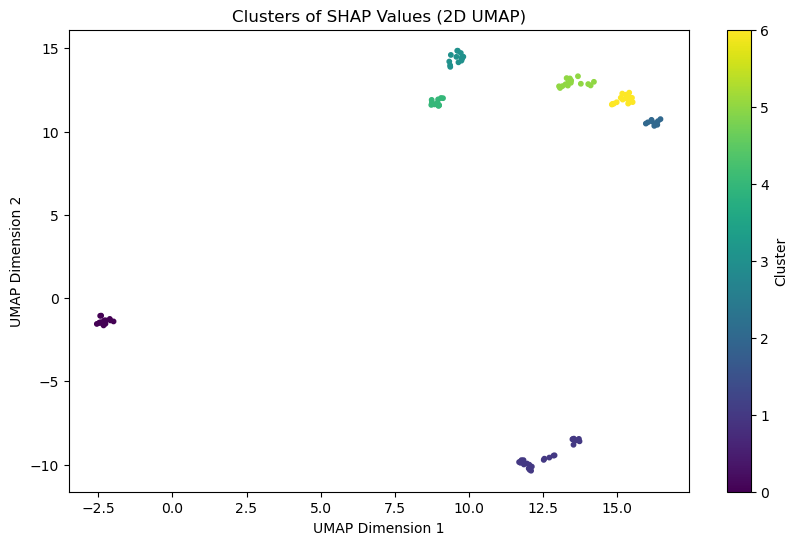

In [104]:
from umap.umap_ import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

# Dimensionality reduction using UMAP with fixed randomness
shap_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0, random_state=42).fit_transform(shap_values.values)

# Clustering using HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
cluster_labels = hdbscan.fit_predict(shap_2d)

print("HDBSCAN Clustering complete!")

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
plt.scatter(shap_2d[:, 0], shap_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar(label="Cluster")
plt.title("Clusters of SHAP Values (2D UMAP)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


In [105]:
from sklearn.metrics import silhouette_score

score = silhouette_score(shap_2d, cluster_labels)
print(f"Silhouette Score: {score}")


Silhouette Score: 0.8566604852676392


In [106]:
import pandas as pd

cluster_data = pd.DataFrame(shap_values.values, columns=X.columns)
cluster_data['Cluster'] = cluster_labels
print(cluster_data.groupby('Cluster').mean())


         sacVolume  sacSurfaceArea  vdcVolume  vdcSurfaceArea  sacSectionArea  \
Cluster                                                                         
0              0.0             0.0  -0.001225             0.0       -0.004691   
1              0.0             0.0  -0.003821             0.0        0.052475   
2              0.0             0.0  -0.003674             0.0        0.066433   
3              0.0             0.0   0.010586             0.0       -0.002745   
4              0.0             0.0  -0.003674             0.0        0.041494   
5              0.0             0.0   0.006941             0.0       -0.219239   
6              0.0             0.0  -0.003674             0.0        0.064670   

         ellipsoidVolume  ellipsoidMaxSemiaxis  ellipsoidMidSemiaxis  \
Cluster                                                                
0              -0.000353             -0.002977             -0.000348   
1               0.029977             -0.006568        

In [107]:
import pandas as pd

# Create a DataFrame for SHAP values
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

# Add cluster labels to the SHAP DataFrame
shap_df['Cluster'] = cluster_labels


In [108]:
# Group by clusters and calculate mean SHAP values
cluster_means = shap_df.groupby('Cluster').mean()

# Display the top SHAP features for each cluster
print(cluster_means.T)


Cluster                            0         1         2         3         4  \
sacVolume                   0.000000  0.000000  0.000000  0.000000  0.000000   
sacSurfaceArea              0.000000  0.000000  0.000000  0.000000  0.000000   
vdcVolume                  -0.001225 -0.003821 -0.003674  0.010586 -0.003674   
vdcSurfaceArea              0.000000  0.000000  0.000000  0.000000  0.000000   
sacSectionArea             -0.004691  0.052475  0.066433 -0.002745  0.041494   
ellipsoidVolume            -0.000353  0.029977 -0.011492 -0.004474 -0.008563   
ellipsoidMaxSemiaxis       -0.002977 -0.006568 -0.009360  0.010327 -0.008913   
ellipsoidMidSemiaxis       -0.000348  0.001884 -0.000531 -0.000125 -0.000661   
ellipsoidMinSemiaxis        0.000000  0.000000  0.000000  0.000000  0.000000   
sacCenterlineLength        -0.003400 -0.010807 -0.010328  0.017233 -0.010328   
ostiumSectionArea           0.000000  0.000000  0.000000  0.000000  0.000000   
ostiumSectionPerimeter     -0.002475 -0.

In [109]:
import pandas as pd
from scipy.stats import chi2_contingency

# Cluster and rupture status data
cluster_df = pd.DataFrame({
    'Cluster': cluster_labels,
    'RuptureStatus': y_encoded  # Assuming y_encoded corresponds to ruptureStatus
})

# Calculate rupture proportions by cluster
rupture_distribution = cluster_df.groupby('Cluster')['RuptureStatus'].mean()
cluster_sizes = cluster_df.groupby('Cluster')['RuptureStatus'].size()

# Create a contingency table for statistical testing
contingency_table = pd.crosstab(cluster_df['Cluster'], cluster_df['RuptureStatus'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

rupture_distribution, cluster_sizes, p_value


(Cluster
 0    0.000000
 1    0.920000
 2    0.500000
 3    0.857143
 4    0.272727
 5    0.266667
 6    0.800000
 Name: RuptureStatus, dtype: float64,
 Cluster
 0    13
 1    25
 2    10
 3    14
 4    11
 5    15
 6    15
 Name: RuptureStatus, dtype: int64,
 1.4558577359773192e-08)

In [110]:
from scipy.stats import chi2_contingency, fisher_exact
from itertools import combinations

# Get unique cluster pairs
cluster_pairs = list(combinations(cluster_df['Cluster'].unique(), 2))

# Perform pairwise comparisons
results = []
for c1, c2 in cluster_pairs:
    sub_table = pd.crosstab(
        cluster_df[cluster_df['Cluster'].isin([c1, c2])]['Cluster'],
        cluster_df[cluster_df['Cluster'].isin([c1, c2])]['RuptureStatus']
    )
    if sub_table.values.min() < 5:  # Use Fisher's Exact Test for small counts
        _, p_value = fisher_exact(sub_table)
        test_type = "Fisher"
    else:  # Use Chi-Square for larger counts
        _, p_value, _, _ = chi2_contingency(sub_table)
        test_type = "Chi-Square"
    results.append({'Cluster Pair': (c1, c2), 'p-value': p_value, 'Test': test_type})

# Adjust for multiple comparisons (Bonferroni correction)
bonferroni_alpha = 0.05 / len(results)  # Adjusted significance level

# Output results
for result in results:
    result['Significant'] = result['p-value'] < bonferroni_alpha
    print(result)


{'Cluster Pair': (1, 6), 'p-value': 0.3446128314549367, 'Test': 'Fisher', 'Significant': False}
{'Cluster Pair': (1, 5), 'p-value': 3.498480865834341e-05, 'Test': 'Fisher', 'Significant': True}
{'Cluster Pair': (1, 2), 'p-value': 0.012041008131435403, 'Test': 'Fisher', 'Significant': False}
{'Cluster Pair': (1, 0), 'p-value': 1.939075970421428e-08, 'Test': 'Fisher', 'Significant': True}
{'Cluster Pair': (1, 4), 'p-value': 0.00020019131122971987, 'Test': 'Fisher', 'Significant': True}
{'Cluster Pair': (1, 3), 'p-value': 0.6085153979890822, 'Test': 'Fisher', 'Significant': False}
{'Cluster Pair': (6, 5), 'p-value': 0.009220570313398513, 'Test': 'Fisher', 'Significant': False}
{'Cluster Pair': (6, 2), 'p-value': 0.19355107135427502, 'Test': 'Fisher', 'Significant': False}
{'Cluster Pair': (6, 0), 'p-value': 1.538372786185412e-05, 'Test': 'Fisher', 'Significant': True}
{'Cluster Pair': (6, 4), 'p-value': 0.01493808049535604, 'Test': 'Fisher', 'Significant': False}
{'Cluster Pair': (6, 3), 

In [111]:
X.columns

Index(['sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane'],
      dtype='object')

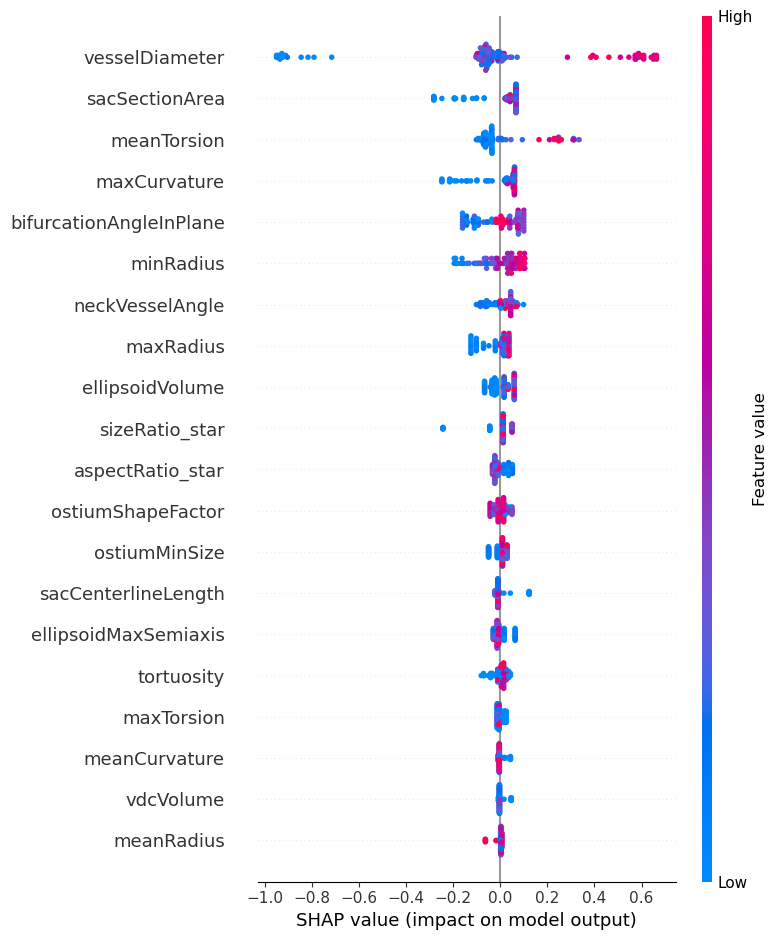

In [112]:
import shap

# Plot the summary plot
shap.summary_plot(shap_values.values, features=X_scaled, feature_names=X.columns)


[21:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


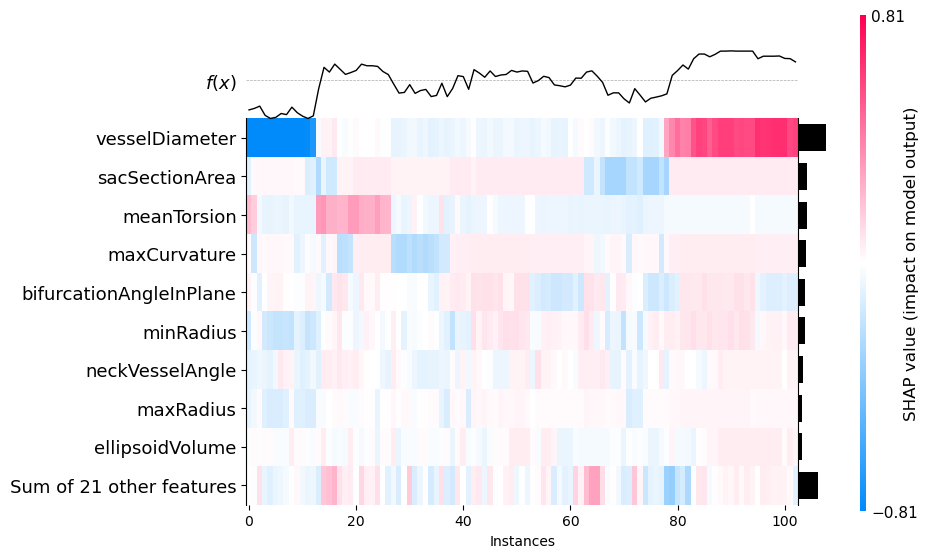

In [113]:
explainer = shap.Explainer(xgb_model, X_scaled, feature_names=X.columns)
shap_values = explainer(X_scaled)

shap.plots.heatmap(shap_values)


In [114]:
# Mean SHAP values by cluster
cluster_summary = cluster_data.groupby('Cluster').mean()
print(cluster_summary)


         sacVolume  sacSurfaceArea  vdcVolume  vdcSurfaceArea  sacSectionArea  \
Cluster                                                                         
0              0.0             0.0  -0.001225             0.0       -0.004691   
1              0.0             0.0  -0.003821             0.0        0.052475   
2              0.0             0.0  -0.003674             0.0        0.066433   
3              0.0             0.0   0.010586             0.0       -0.002745   
4              0.0             0.0  -0.003674             0.0        0.041494   
5              0.0             0.0   0.006941             0.0       -0.219239   
6              0.0             0.0  -0.003674             0.0        0.064670   

         ellipsoidVolume  ellipsoidMaxSemiaxis  ellipsoidMidSemiaxis  \
Cluster                                                                
0              -0.000353             -0.002977             -0.000348   
1               0.029977             -0.006568        

In [115]:
# Add cluster labels to the original dataset
original_data = data[characteristics].copy()
original_data['Cluster'] = cluster_labels

# Select only numeric columns
numeric_columns = original_data.select_dtypes(include=np.number)

# Calculate mean feature values for each cluster (true values)
true_cluster_summary = numeric_columns.groupby(original_data['Cluster']).mean()

# Display the mean true values by cluster
print(true_cluster_summary)


          sacVolume  sacSurfaceArea   vdcVolume  vdcSurfaceArea  \
Cluster                                                           
0        163.215660      139.741336  136.739951      113.638379   
1        381.118484      228.275417  349.969619      207.769990   
2        189.701285      145.582663  169.211597      129.888245   
3        133.416911      102.468613  124.882300       94.858675   
4        199.897777      140.741744  184.861693      128.167976   
5         25.606440       39.453334   24.101844       36.875504   
6        226.552754      158.899814  200.045678      138.605691   

         sacSectionArea  ellipsoidVolume  ellipsoidMaxSemiaxis  \
Cluster                                                          
0             28.753349        90.370143              3.623238   
1             50.586259       259.866211              4.439012   
2             33.444258       113.151711              3.693460   
3             23.818263       106.918510              3.243367   


In [116]:
cluster_df['Prediction'] = xgb_model.predict(X_scaled)
cluster_accuracy = cluster_df.groupby('Cluster').apply(lambda x: (x['Prediction'] == x['RuptureStatus']).mean())
print(cluster_accuracy)


Cluster
0    1.000000
1    0.960000
2    0.500000
3    0.857143
4    1.000000
5    0.933333
6    0.866667
dtype: float64


DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [117]:
import shap
import seaborn as sns
shap.initjs()

# Assuming you used StandardScaler for scaling the features
original_values = scaler.inverse_transform(X_scaled[:1000])

# Generate the force plot using original feature values
shap.force_plot(
    explainer.expected_value,
    shap_values.values[:1000],
    original_values,
    feature_names=X.columns
)

# Save the force plot with original feature values
shap.save_html('force_plot.html', shap.force_plot(
    explainer.expected_value,
    shap_values.values[:1000],
    original_values,
    feature_names=X.columns
))


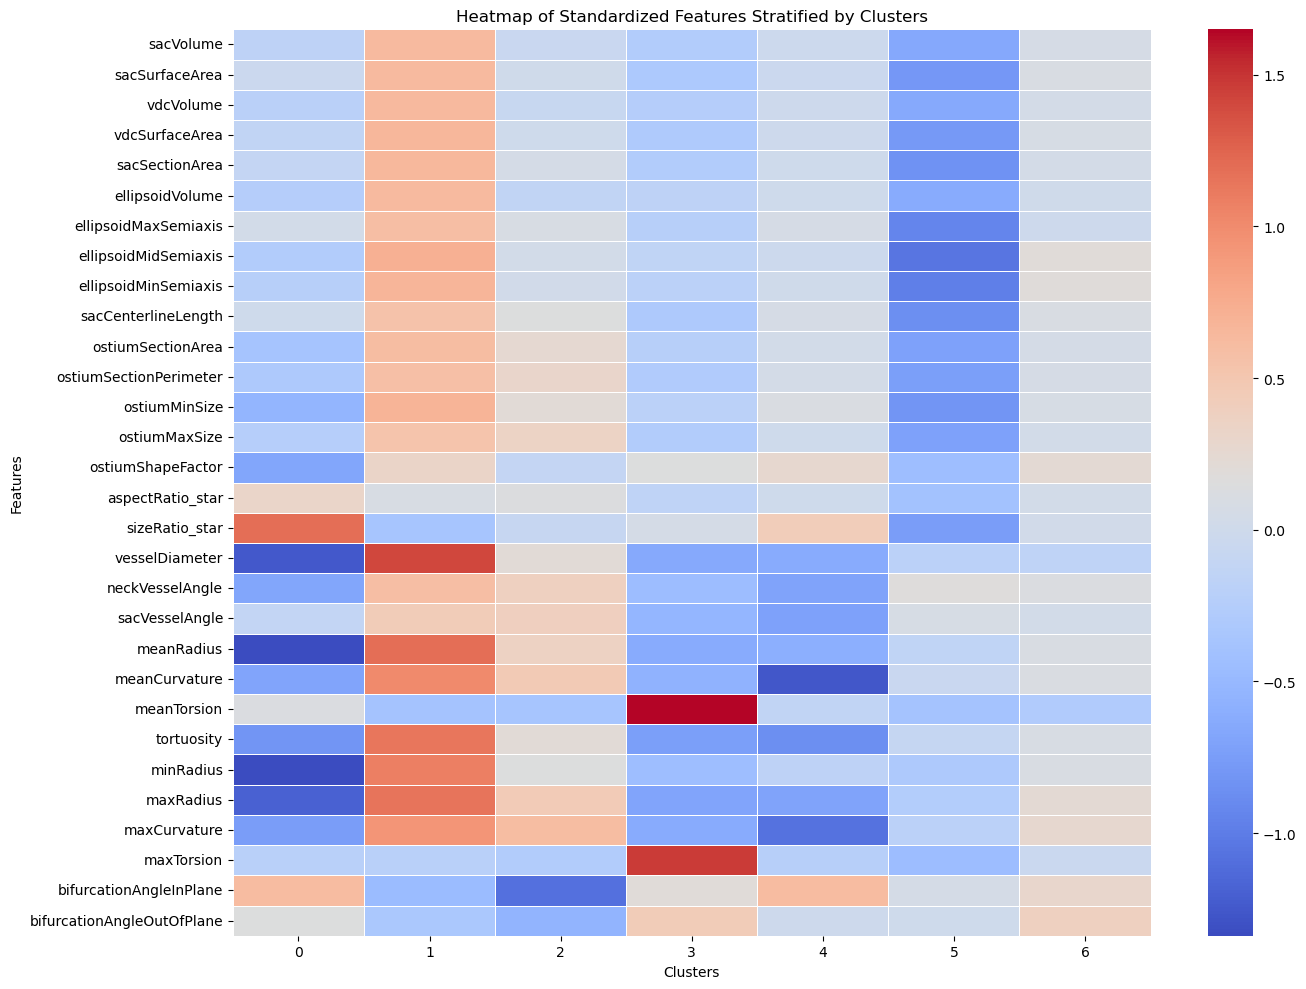

In [118]:
# Dropping specified non-numeric features and 'age' from numeric columns
numeric_features_filtered = original_data.drop(columns=['Cluster'])

# Standardizing the numeric features
standardized_features_filtered = pd.DataFrame(
    scaler.fit_transform(numeric_features_filtered),
    columns=numeric_features_filtered.columns
)

# Adding the cluster labels back to the standardized data
standardized_features_filtered['Cluster'] = original_data['Cluster']

# Calculating the mean of each feature grouped by cluster
cluster_feature_means_filtered = standardized_features_filtered.groupby('Cluster').mean().T

# Creating the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_feature_means_filtered, cmap='coolwarm', annot=False, cbar=True, linewidths=0.5)
plt.title("Heatmap of Standardized Features Stratified by Clusters")
plt.xlabel("Clusters")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [119]:
X.columns

Index(['sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane'],
      dtype='object')

In [121]:
# Add 'aneurysmLocation' and 'aneurysmType' from the original data to X
X['aneurysmLocation'] = data['aneurysmLocation']
X['aneurysmType'] = data['aneurysmType']

# Drop 'aneurysmLocation_BAS' and 'aneurysmLocation_ICA' to maintain the same number of features
# Verify the columns have been updated
print(X.columns)


Index(['sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation', 'aneurysmType'],
      dtype='object')


In [122]:
X.shape

(103, 32)

In [123]:
# Re-creating the scenario with sample data

import numpy as np

# Assuming shap_values is a NumPy array with shape (103, 30)
# Create a fake thin layer of zeros to match the additional columns
shap_values_array = np.random.random((103, 30))  # Placeholder for the original SHAP values array
missing_columns = 32 - shap_values_array.shape[1]
fake_values = np.zeros((shap_values_array.shape[0], missing_columns))

# Add the fake values as new columns
shap_values = np.hstack((shap_values_array, fake_values))

# Verify the new shape
shap_values.shape


(103, 32)

In [124]:
shap_values.shape

(103, 32)

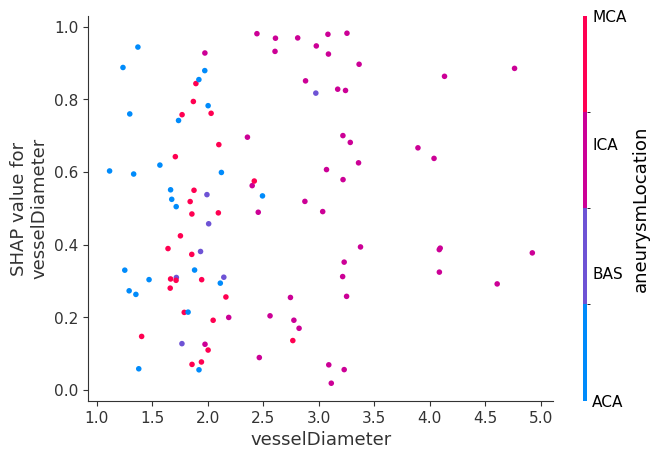

In [125]:
# Assuming `shap_values` is now a NumPy array and not a SHAP object
shap.dependence_plot(
    'vesselDiameter', 
    shap_values,  # Pass directly as this is already an array
    X, 
    interaction_index='aneurysmLocation', 
    feature_names=X.columns
)


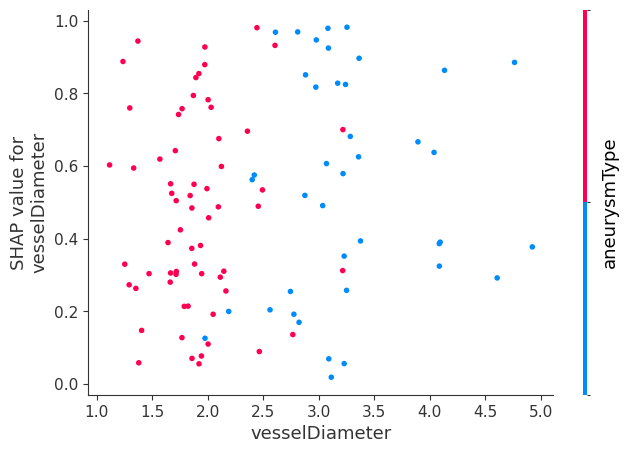

"\n(aneurysmType\n LAT    3.251116\n TER    1.892105\n Name: vesselDiameter, dtype: float64,\n 'TER',\n 'LAT')\n The red points in the SHAP dependence plot correspond to the aneurysm type with the lower mean vesselDiameter, which is TER.\nThe blue points correspond to the aneurysm type with the higher mean vesselDiameter, which is LAT.\n"

In [127]:
shap.dependence_plot('vesselDiameter', shap_values, X, interaction_index='aneurysmType', feature_names=X.columns)

"""
(aneurysmType
 LAT    3.251116
 TER    1.892105
 Name: vesselDiameter, dtype: float64,
 'TER',
 'LAT')
 The red points in the SHAP dependence plot correspond to the aneurysm type with the lower mean vesselDiameter, which is TER.
The blue points correspond to the aneurysm type with the higher mean vesselDiameter, which is LAT.
"""

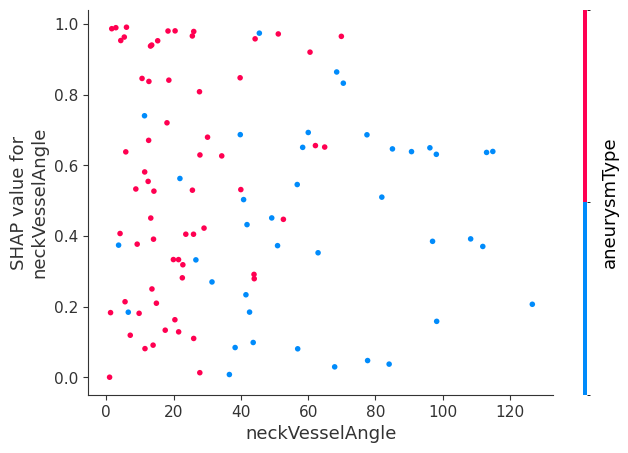

In [129]:
shap.dependence_plot('neckVesselAngle', shap_values, X, interaction_index='aneurysmType', feature_names=X.columns)


In [130]:
X.columns

Index(['sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'aneurysmLocation', 'aneurysmType'],
      dtype='object')

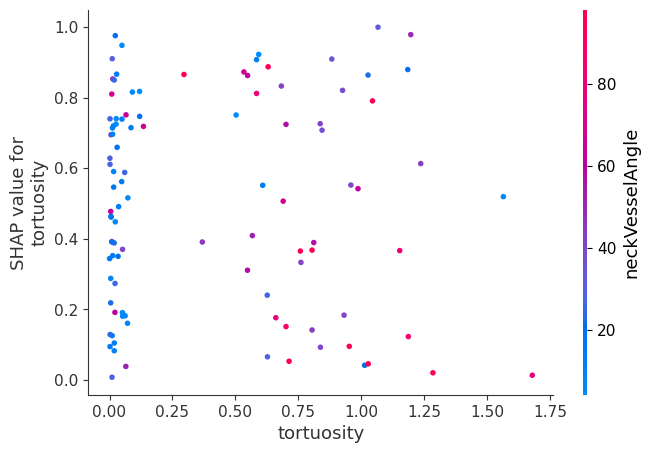

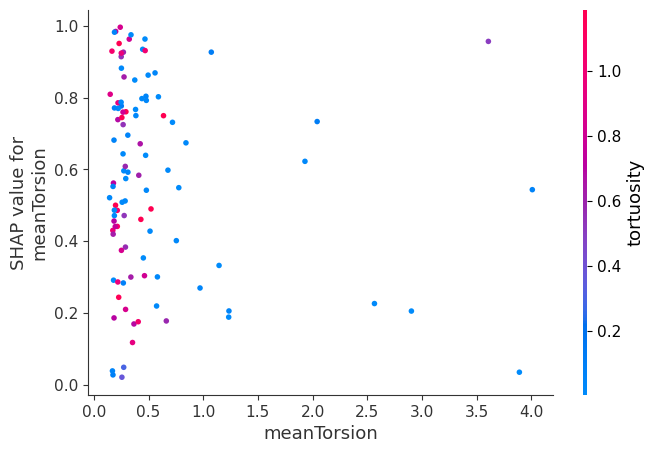

In [131]:
shap.dependence_plot('tortuosity', shap_values, X, interaction_index='neckVesselAngle', feature_names=X.columns)
shap.dependence_plot('meanTorsion', shap_values, X, interaction_index='tortuosity', feature_names=X.columns)


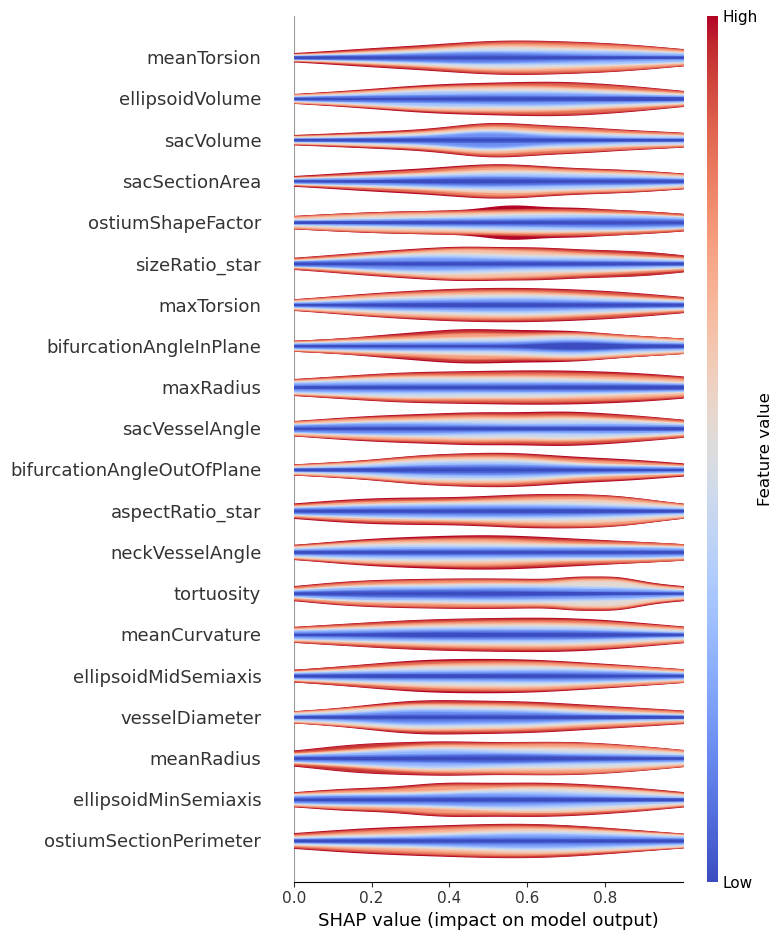

In [132]:
# Display all features in the SHAP summary plot
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type="layered_violin")


In [133]:
from skrules import SkopeRules


# Add cluster labels to the original dataset
original_data = data[characteristics].copy()
original_data['Cluster'] = cluster_labels

# Select only numeric columns for rule generation
numeric_columns = original_data.select_dtypes(include=np.number).columns
numeric_data = original_data[numeric_columns]

# Include the cluster labels in the rule generation dataset
numeric_data['Cluster'] = cluster_labels
from sklearn.impute import SimpleImputer

# Impute missing values for numeric data
imputer = SimpleImputer(strategy='mean')  # Use 'mean' to fill missing values
numeric_data_imputed = pd.DataFrame(imputer.fit_transform(numeric_data), 
                                    columns=numeric_data.columns)

# Ensure the Cluster column is properly aligned
numeric_data_imputed['Cluster'] = cluster_labels


In [134]:
from skrules import SkopeRules

rules_per_cluster = {}

# Loop through each cluster to generate rules
for cluster in np.unique(cluster_labels):
    print(f"Generating rules for Cluster {cluster}...")
    
    # Create a binary target for the current cluster
    numeric_data_imputed['IsCluster'] = (numeric_data_imputed['Cluster'] == cluster).astype(int)
    
    # Initialize and train SkopeRules
    skope = SkopeRules(max_depth=4, n_estimators=30, precision_min=0.5)
    skope.fit(numeric_data_imputed.drop(columns=['Cluster', 'IsCluster']), numeric_data_imputed['IsCluster'])
    
    # Extract and store the rules
    rules = skope.rules_
    rules_per_cluster[cluster] = rules

# Print the rules for each cluster
for cluster, rules in rules_per_cluster.items():
    print(f"\nCluster {cluster} Rules:")
    for rule in rules:
        print(rule)


Generating rules for Cluster 0...


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Generating rules for Cluster 1...


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Generating rules for Cluster 2...


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Generating rules for Cluster 3...


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Generating rules for Cluster 4...


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Generating rules for Cluster 5...


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Generating rules for Cluster 6...


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.



Cluster 0 Rules:
('__C__17 <= 1.650891900062561', (1.0, 1.0, 28))
('__C__17 <= 1.6526591777801514', (1.0, 1.0, 8))
('__C__17 <= 1.6143537163734436', (1.0, 0.7214285714285715, 7))
('__C__17 <= 1.5672898292541504', (1.0, 0.5, 1))
('__C__17 <= 1.56552255153656', (1.0, 0.5, 1))

Cluster 1 Rules:
('__C__17 > 3.083630681037903', (1.0, 1.0, 40))
('__C__17 > 3.0852437019348145', (1.0, 1.0, 7))
('__C__17 > 3.0788254737854004', (0.849702380952381, 1.0, 4))
('__C__17 > 3.0772124528884888', (0.8142857142857143, 1.0, 4))
('__C__17 > 3.061681389808655', (0.75, 1.0, 1))
('__C__17 > 3.060068368911743', (0.7321428571428572, 1.0, 2))
('__C__17 > 3.0900750160217285', (1.0, 0.6666666666666666, 1))

Cluster 2 Rules:
('__C__17 <= 3.0514222383499146 and __C__21 > 0.04359690099954605 and __C__28 <= 109.35855102539062 and __C__4 > 11.701019763946533', (1.0, 1.0, 1))
('__C__17 <= 3.137006402015686 and __C__23 > 0.008150957291945815 and __C__28 <= 109.5334587097168 and __C__4 > 12.243110179901123', (1.0, 1.0, 1

In [135]:
import re

# Manually define the feature mapping
feature_map = {
    "__C__0": "age",
    "__C__1": "sacVolume",
    "__C__2": "sacSurfaceArea",
    "__C__3": "vdcVolume",
    "__C__4": "vdcSurfaceArea",
    "__C__5": "sacSectionArea",
    "__C__6": "ellipsoidVolume",
    "__C__7": "ellipsoidMaxSemiaxis",
    "__C__8": "ellipsoidMidSemiaxis",
    "__C__9": "ellipsoidMinSemiaxis",
    "__C__10": "sacCenterlineLength",
    "__C__11": "ostiumSectionArea",
    "__C__12": "ostiumSectionPerimeter",
    "__C__13": "ostiumMinSize",
    "__C__14": "ostiumMaxSize",
    "__C__15": "ostiumShapeFactor",
    "__C__16": "aspectRatio_star",
    "__C__17": "sizeRatio_star",
    "__C__18": "vesselDiameter",
    "__C__19": "neckVesselAngle",
    "__C__20": "sacVesselAngle",
    "__C__21": "meanRadius",
    "__C__22": "meanCurvature",
    "__C__23": "meanTorsion",
    "__C__24": "tortuosity",
    "__C__25": "minRadius",
    "__C__26": "maxRadius",
    "__C__27": "maxCurvature",
    "__C__28": "maxTorsion",
    "__C__29": "bifurcationAngleInPlane",
    "__C__30": "bifurcationAngleOutOfPlane"
}

# Function to replace placeholders with feature names using exact matches
def replace_placeholders(rule, feature_map):
    condition, stats = rule
    for placeholder, feature_name in feature_map.items():
        # Use regex to replace exact matches of placeholders only
        condition = re.sub(rf'\b{re.escape(placeholder)}\b', feature_name, condition)
    return f"{condition} (Support: {stats[2]}, Precision: {stats[0]}, Recall: {stats[1]})"

# Replace placeholders for all clusters
for cluster, rules in rules_per_cluster.items():
    print(f"\nCluster {cluster} Mapped Rules:")
    for rule in rules:
        print(replace_placeholders(rule, feature_map))



Cluster 0 Mapped Rules:
sizeRatio_star <= 1.650891900062561 (Support: 28, Precision: 1.0, Recall: 1.0)
sizeRatio_star <= 1.6526591777801514 (Support: 8, Precision: 1.0, Recall: 1.0)
sizeRatio_star <= 1.6143537163734436 (Support: 7, Precision: 1.0, Recall: 0.7214285714285715)
sizeRatio_star <= 1.5672898292541504 (Support: 1, Precision: 1.0, Recall: 0.5)
sizeRatio_star <= 1.56552255153656 (Support: 1, Precision: 1.0, Recall: 0.5)

Cluster 1 Mapped Rules:
sizeRatio_star > 3.083630681037903 (Support: 40, Precision: 1.0, Recall: 1.0)
sizeRatio_star > 3.0852437019348145 (Support: 7, Precision: 1.0, Recall: 1.0)
sizeRatio_star > 3.0788254737854004 (Support: 4, Precision: 0.849702380952381, Recall: 1.0)
sizeRatio_star > 3.0772124528884888 (Support: 4, Precision: 0.8142857142857143, Recall: 1.0)
sizeRatio_star > 3.061681389808655 (Support: 1, Precision: 0.75, Recall: 1.0)
sizeRatio_star > 3.060068368911743 (Support: 2, Precision: 0.7321428571428572, Recall: 1.0)
sizeRatio_star > 3.090075016021

In [136]:
print(numeric_data_imputed.columns)


Index(['sacVolume', 'sacSurfaceArea', 'vdcVolume', 'vdcSurfaceArea',
       'sacSectionArea', 'ellipsoidVolume', 'ellipsoidMaxSemiaxis',
       'ellipsoidMidSemiaxis', 'ellipsoidMinSemiaxis', 'sacCenterlineLength',
       'ostiumSectionArea', 'ostiumSectionPerimeter', 'ostiumMinSize',
       'ostiumMaxSize', 'ostiumShapeFactor', 'aspectRatio_star',
       'sizeRatio_star', 'vesselDiameter', 'neckVesselAngle', 'sacVesselAngle',
       'meanRadius', 'meanCurvature', 'meanTorsion', 'tortuosity', 'minRadius',
       'maxRadius', 'maxCurvature', 'maxTorsion', 'bifurcationAngleInPlane',
       'bifurcationAngleOutOfPlane', 'Cluster', 'IsCluster'],
      dtype='object')


In [137]:
print(feature_map)


{'__C__0': 'age', '__C__1': 'sacVolume', '__C__2': 'sacSurfaceArea', '__C__3': 'vdcVolume', '__C__4': 'vdcSurfaceArea', '__C__5': 'sacSectionArea', '__C__6': 'ellipsoidVolume', '__C__7': 'ellipsoidMaxSemiaxis', '__C__8': 'ellipsoidMidSemiaxis', '__C__9': 'ellipsoidMinSemiaxis', '__C__10': 'sacCenterlineLength', '__C__11': 'ostiumSectionArea', '__C__12': 'ostiumSectionPerimeter', '__C__13': 'ostiumMinSize', '__C__14': 'ostiumMaxSize', '__C__15': 'ostiumShapeFactor', '__C__16': 'aspectRatio_star', '__C__17': 'sizeRatio_star', '__C__18': 'vesselDiameter', '__C__19': 'neckVesselAngle', '__C__20': 'sacVesselAngle', '__C__21': 'meanRadius', '__C__22': 'meanCurvature', '__C__23': 'meanTorsion', '__C__24': 'tortuosity', '__C__25': 'minRadius', '__C__26': 'maxRadius', '__C__27': 'maxCurvature', '__C__28': 'maxTorsion', '__C__29': 'bifurcationAngleInPlane', '__C__30': 'bifurcationAngleOutOfPlane'}


In [138]:
for cluster, rules in rules_per_cluster.items():
    print(f"Raw Rules for Cluster {cluster}: {rules}")


Raw Rules for Cluster 0: [('__C__17 <= 1.650891900062561', (1.0, 1.0, 28)), ('__C__17 <= 1.6526591777801514', (1.0, 1.0, 8)), ('__C__17 <= 1.6143537163734436', (1.0, 0.7214285714285715, 7)), ('__C__17 <= 1.5672898292541504', (1.0, 0.5, 1)), ('__C__17 <= 1.56552255153656', (1.0, 0.5, 1))]
Raw Rules for Cluster 1: [('__C__17 > 3.083630681037903', (1.0, 1.0, 40)), ('__C__17 > 3.0852437019348145', (1.0, 1.0, 7)), ('__C__17 > 3.0788254737854004', (0.849702380952381, 1.0, 4)), ('__C__17 > 3.0772124528884888', (0.8142857142857143, 1.0, 4)), ('__C__17 > 3.061681389808655', (0.75, 1.0, 1)), ('__C__17 > 3.060068368911743', (0.7321428571428572, 1.0, 2)), ('__C__17 > 3.0900750160217285', (1.0, 0.6666666666666666, 1))]
Raw Rules for Cluster 2: [('__C__17 <= 3.0514222383499146 and __C__21 > 0.04359690099954605 and __C__28 <= 109.35855102539062 and __C__4 > 11.701019763946533', (1.0, 1.0, 1)), ('__C__17 <= 3.137006402015686 and __C__23 > 0.008150957291945815 and __C__28 <= 109.5334587097168 and __C__

In [139]:
# Rank rules by precision and support
ranked_rules = {}

for cluster, rules in rules_per_cluster.items():
    ranked_rules[cluster] = sorted(
        rules, key=lambda x: (x[1][0], x[1][2]), reverse=True  # Sort by precision, then support
    )

# Display top-ranked rules for each cluster
for cluster, rules in ranked_rules.items():
    print(f"\nTop Rules for Cluster {cluster}:")
    for rule in rules[:5]:  # Display top 5 rules
        print(replace_placeholders(rule, feature_map))



Top Rules for Cluster 0:
sizeRatio_star <= 1.650891900062561 (Support: 28, Precision: 1.0, Recall: 1.0)
sizeRatio_star <= 1.6526591777801514 (Support: 8, Precision: 1.0, Recall: 1.0)
sizeRatio_star <= 1.6143537163734436 (Support: 7, Precision: 1.0, Recall: 0.7214285714285715)
sizeRatio_star <= 1.5672898292541504 (Support: 1, Precision: 1.0, Recall: 0.5)
sizeRatio_star <= 1.56552255153656 (Support: 1, Precision: 1.0, Recall: 0.5)

Top Rules for Cluster 1:
sizeRatio_star > 3.083630681037903 (Support: 40, Precision: 1.0, Recall: 1.0)
sizeRatio_star > 3.0852437019348145 (Support: 7, Precision: 1.0, Recall: 1.0)
sizeRatio_star > 3.0900750160217285 (Support: 1, Precision: 1.0, Recall: 0.6666666666666666)
sizeRatio_star > 3.0788254737854004 (Support: 4, Precision: 0.849702380952381, Recall: 1.0)
sizeRatio_star > 3.0772124528884888 (Support: 4, Precision: 0.8142857142857143, Recall: 1.0)

Top Rules for Cluster 2:
sizeRatio_star <= 3.0514222383499146 and maxRadius > 0.08111489564180374 and max

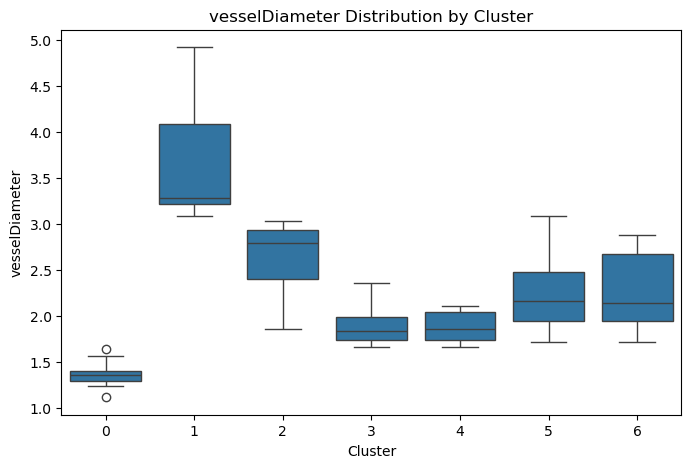

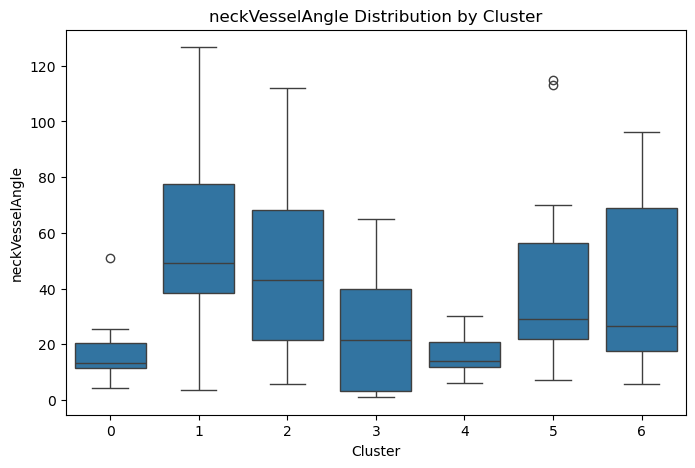

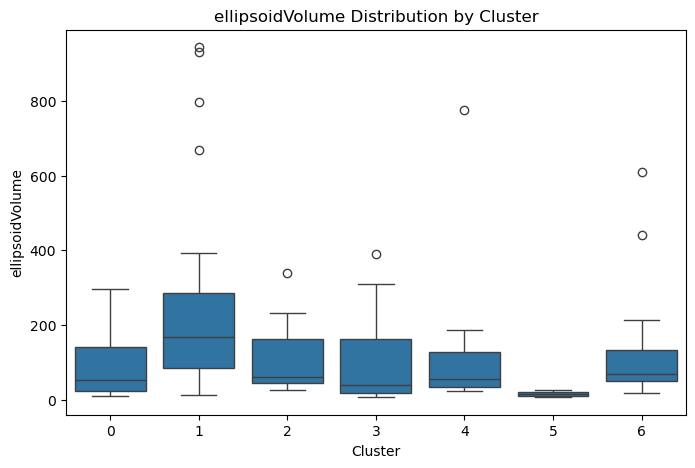

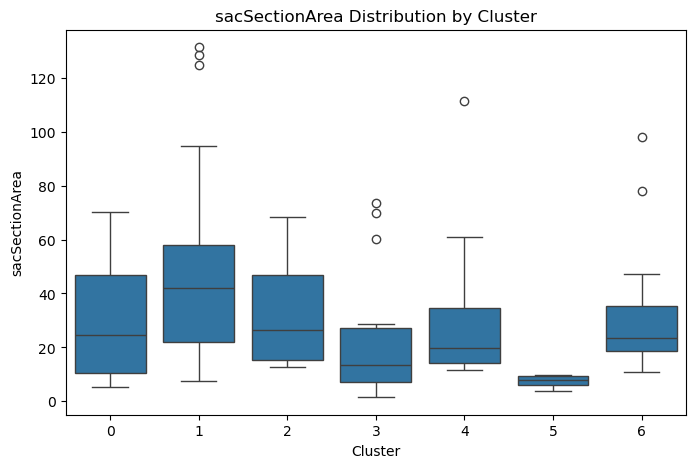

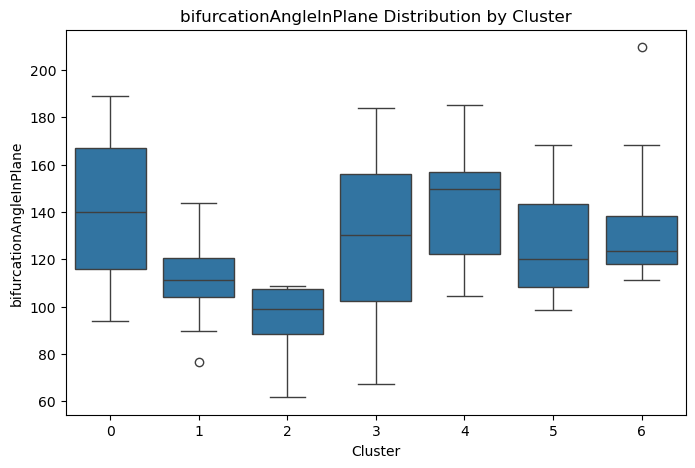

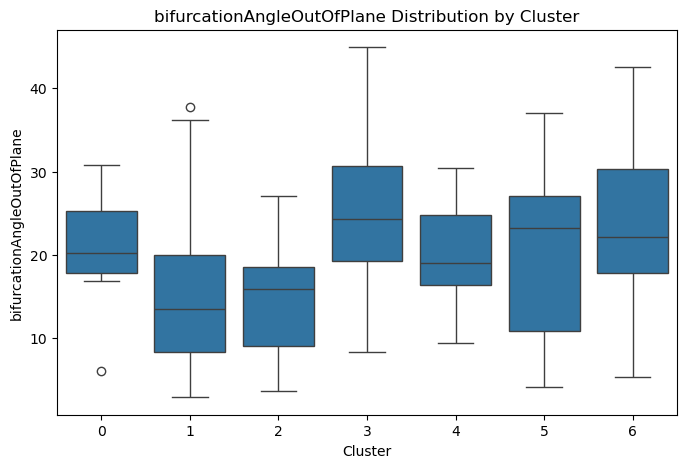

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot feature distributions 
features_to_plot = ['vesselDiameter', 'neckVesselAngle', 'ellipsoidVolume', 'sacSectionArea', 'bifurcationAngleInPlane', 'bifurcationAngleOutOfPlane']
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=original_data, x='Cluster', y=feature)
    plt.title(f'{feature} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.show()


In [141]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict


# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions using cross-validation for the best model
y_pred_prob_best = cross_val_predict(best_model, X_scaled, y_encoded, cv=3, method='predict_proba')[:, 1]

# Calculate AUC-ROC for the best model
auc_roc_best = roc_auc_score(y_encoded, y_pred_prob_best)

# Print the best model's parameters and its AUC-ROC
print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Mean Cross-Validation Accuracy: {grid_search.best_score_:.3f}")
print(f"AUC-ROC Score: {auc_roc_best:.3f}")


Best Model Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Mean Cross-Validation Accuracy: 0.709
AUC-ROC Score: 0.707
